In [1]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, timeit, json
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from collections import OrderedDict, deque, defaultdict
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np, pandas as pd, scipy
from scipy.stats import zscore, ttest_ind, spearmanr, pearsonr
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP

torch.set_num_threads(16)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
context = dict(device='cuda:0', dtype=torch.float32)

In [15]:
def reload_all():
    import model, load_data, estimate_parameters, estimate_weights, util, initialization, sample_for_integral
    importlib.reload(util)
    importlib.reload(load_data)
    importlib.reload(sample_for_integral)
    importlib.reload(estimate_parameters)
    importlib.reload(estimate_weights)
    importlib.reload(initialization)
    importlib.reload(model)

reload_all()

In [16]:
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i4')
path2dataset = Path('/work/magroup/shahula/spatiotemporal_transcriptomics_integration/SpiceMixPlus/tests/test_data/synthetic_500_100_20_15_0_0_i4')
# repli_list = ['0', '1']
repli_list = ['0']

# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/spatialLIBD_old_spicemix_correct_edges')
# repli_list = ['151507','151508']

In [17]:
df_meta = []
for r in repli_list:
#     df = pd.read_csv(path2dataset / 'files' / f'meta_{r}.csv')
    df = pd.read_csv(path2dataset / 'files' / f'celltypes_{r}.txt', header=None)
    df.columns = ['cell type']
    df['repli'] = r
    df_meta.append(df)
df_meta = pd.concat(df_meta, axis=0).reset_index(drop=True)
df_meta['cell type'] = pd.Categorical(df_meta['cell type'], categories=np.unique(df_meta['cell type']))

In [22]:
%%time
reload_all()
from model import SpiceMixPlus
from util import clustering_louvain_nclust
from sklearn.cluster import AgglomerativeClustering

def do_umap(obj):
    Xs = [X.cpu().numpy() for X in obj.Xs]

    x = np.concatenate(Xs, axis=0)
    x = StandardScaler().fit_transform(x)
    
#     y = AgglomerativeClustering(
#         n_clusters=8,
#         linkage='ward',
#     ).fit_predict(x)
#     y = pd.Categorical(y, categories=np.unique(y))
    y = clustering_louvain_nclust(
        x.copy(), 8,
        kwargs_neighbors=dict(n_neighbors=10),
        kwargs_clustering=dict(),
        resolution_boundaries=(.1, 1.),
    )
    df_meta['label SpiceMixPlus'] = y
    print('ari', adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
    plt.figure()
    sns.heatmap(
        df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
        annot=True, fmt='d',
    )
    plt.show()
    plt.close()
    
    x = UMAP(
        n_neighbors=10,
    ).fit_transform(x)
    print('sil', silhouette_score(x, df_meta['cell type']))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, key in zip(axes.flat, ['cell type', 'repli', 'label SpiceMixPlus']):
        sns.scatterplot(ax=ax, data=df_meta, x=x[:, 0], y=x[:, 1], hue=key, s=5)
    plt.show()
    plt.close()
# obj = SpiceMixPlus(
#     K=10, lambda_Sigma_x_inv=1e-5,
#     repli_list=repli_list,
#     context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
# )
# obj.load_dataset(path2dataset)
# obj.initialize(
# #     method='kmeans',
#     method='svd',
# )
# obj.initialize_Sigma_x_inv()
# Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
# for iiter in trange(20):
#     obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
#     obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
# do_umap(obj)
# obj.initialize_Sigma_x_inv()
# # torch.manual_seed(0)
# # import numpy as np
# # np.random.seed(0)
# for iteration in range(1, 5):
#     obj.estimate_parameters(iiter=iteration, use_spatial=[True]*obj.num_repli)
#     obj.estimate_weights(iiter=iteration, use_spatial=[True]*obj.num_repli)
#     if iteration % 10 == 0:
#         do_umap(obj)
obj = SpiceMixPlus(
    K=10, lambda_Sigma_x_inv=1e-5,                                                                                                                                                                                                                        
    repli_list=[0],
    context=dict(device='cuda:0', dtype=torch.float32),
    context_Y=dict(dtype=torch.float32, device='cpu'),
)   
obj.load_dataset(path2dataset)
obj.initialize(
#     method='kmeans',
    method='svd',
)   

obj.initialize_Sigma_x_inv()
# torch.manual_seed(0)
# import numpy as np
# np.random.seed(0)
for iteration in range(1, 5): 
    obj.estimate_parameters(iiter=iteration, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iteration, use_spatial=[True]*obj.num_repli)

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3min 22s, sys: 2.91 s, total: 3min 25s
Wall time: 3min 5s


In [24]:
Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/Sigma_x_inv.npy", Sigma_x_inv)

M = obj.M.detach().cpu().numpy()
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/M.npy", M)

X_0 = obj.Xs[0].detach().cpu().numpy()
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/X_0.npy", X_0)

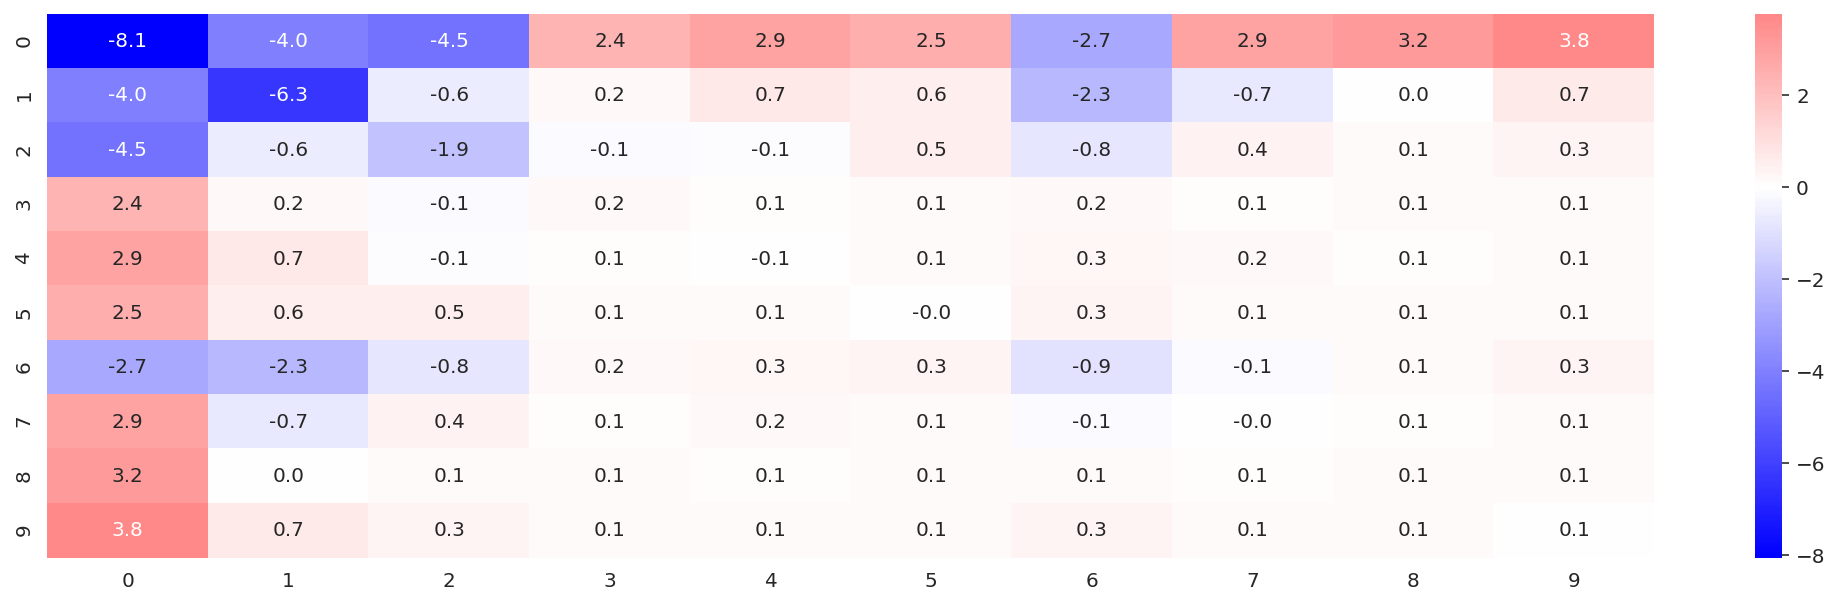

In [27]:
Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
fig, axes = plt.subplots(1, 1, figsize=(18, 5), squeeze=False)
kwargs = dict(
    annot=True,
    fmt='.1f',
    cmap='bwr',
    center=0,
)
for ax, x in zip(axes.flat, [Sigma_x_inv]):
    sns.heatmap(x, ax=ax, **kwargs)

In [53]:
import pytest

#@pytest.fixture
def spicemix_with_neighbors():                                                                                                                                                                                                                                   
    path2dataset = Path('../tests/test_data/synthetic_500_100_20_15_0_0_i4')
    obj = SpiceMixPlus(
        K=10, lambda_Sigma_x_inv=1e-5,
        repli_list=[0],
        context=dict(device='cuda:0', dtype=torch.float32),
        context_Y=dict(dtype=torch.float32, device='cpu'),
    )   
    obj.load_dataset(path2dataset)
    obj.initialize(
    #     method='kmeans',
        method='svd',
    )   

    obj.initialize_Sigma_x_inv()
    # torch.manual_seed(0)
    # import numpy as np
    # np.random.seed(0)
    for iteration in range(1, 5):
        obj.estimate_parameters(iiter=iteration, use_spatial=[True]*obj.num_repli)
        obj.estimate_weights(iiter=iteration, use_spatial=[True]*obj.num_repli)
                
    return obj

def spicemix_without_neighbors():                                                                                                                                                                                                                                   
    path2dataset = Path('../tests/test_data/synthetic_500_100_20_15_0_0_i4')
    obj = SpiceMixPlus(
        K=10, lambda_Sigma_x_inv=1e-5,
        repli_list=[0],
        context=dict(device='cuda:0', dtype=torch.float32),
        context_Y=dict(dtype=torch.float32, device='cpu'),
    )   
    obj.load_dataset(path2dataset)
    obj.initialize(
    #     method='kmeans',
        method='svd',
    )   
    obj.initialize_Sigma_x_inv()
    for iiter in trange(20):
        obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
        obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)

        
def test_Sigma_x_inv(example_spicemix_run):
    Sigma_x_inv = example_spicemix_run.Sigma_x_inv.detach().cpu().numpy()
    test_Sigma_x_inv = np.load("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/Sigma_x_inv.npy")
    assert np.allclose(test_Sigma_x_inv, Sigma_x_inv)
    
def test_M():
    test_M = np.load("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/M.npy")
    M = obj.M.detach().cpu().numpy()
    assert np.allclose(test_M, M)
    
def test_X_0():
    test_X_0 = np.load("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/X_0.npy")
    X_0 = obj.Xs[0].detach().cpu().numpy()
    assert np.allclose(test_X_0, X_0)
    
def test_louvain_clustering():
    Xs = [X.cpu().numpy() for X in obj.Xs]

    x = np.concatenate(Xs, axis=0)
    x = StandardScaler().fit_transform(x)
    
    y = clustering_louvain_nclust(
        x.copy(), 8,
        kwargs_neighbors=dict(n_neighbors=10),
        kwargs_clustering=dict(),
        resolution_boundaries=(.1, 1.),
    )
    
    df_meta['label SpiceMixPlus'] = y
    ari = adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T)
    print(ari)
    assert 0.5983583723816454 == pytest.approx(ari)
        
    silhouette = silhouette_score(x, df_meta['cell type'])
    print(silhouette)
    assert 0.16432503 == pytest.approx(silhouette)
    
test_Sigma_x_inv(example_spicemix_run)
test_M()
test_X_0()

test_louvain_clustering()

AttributeError: 'function' object has no attribute 'Sigma_x_inv'

In [49]:
# obj = spicemix_with_neighbors()
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/Sigma_x_inv.npy", obj.Sigma_x_inv.detach().cpu().numpy())
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/M.npy", obj.M.detach().cpu().numpy())
np.save("../tests/test_data/synthetic_500_100_20_15_0_0_i4/outputs/X_0.npy", obj.Xs[0].detach().cpu().numpy())

In [52]:
test_Sigma_x_inv(obj)
test_M()
test_X_0()

test_louvain_clustering()

Louvain clustering: res=3.16e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.10	rb=1.00	mid=0.32	n_clust=7


Louvain clustering: res=5.62e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.32	rb=1.00	mid=0.56	n_clust=10


Louvain clustering: res=4.22e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.32	rb=0.56	mid=0.42	n_clust=8
0.5983583723816454
0.16432503


AssertionError: 

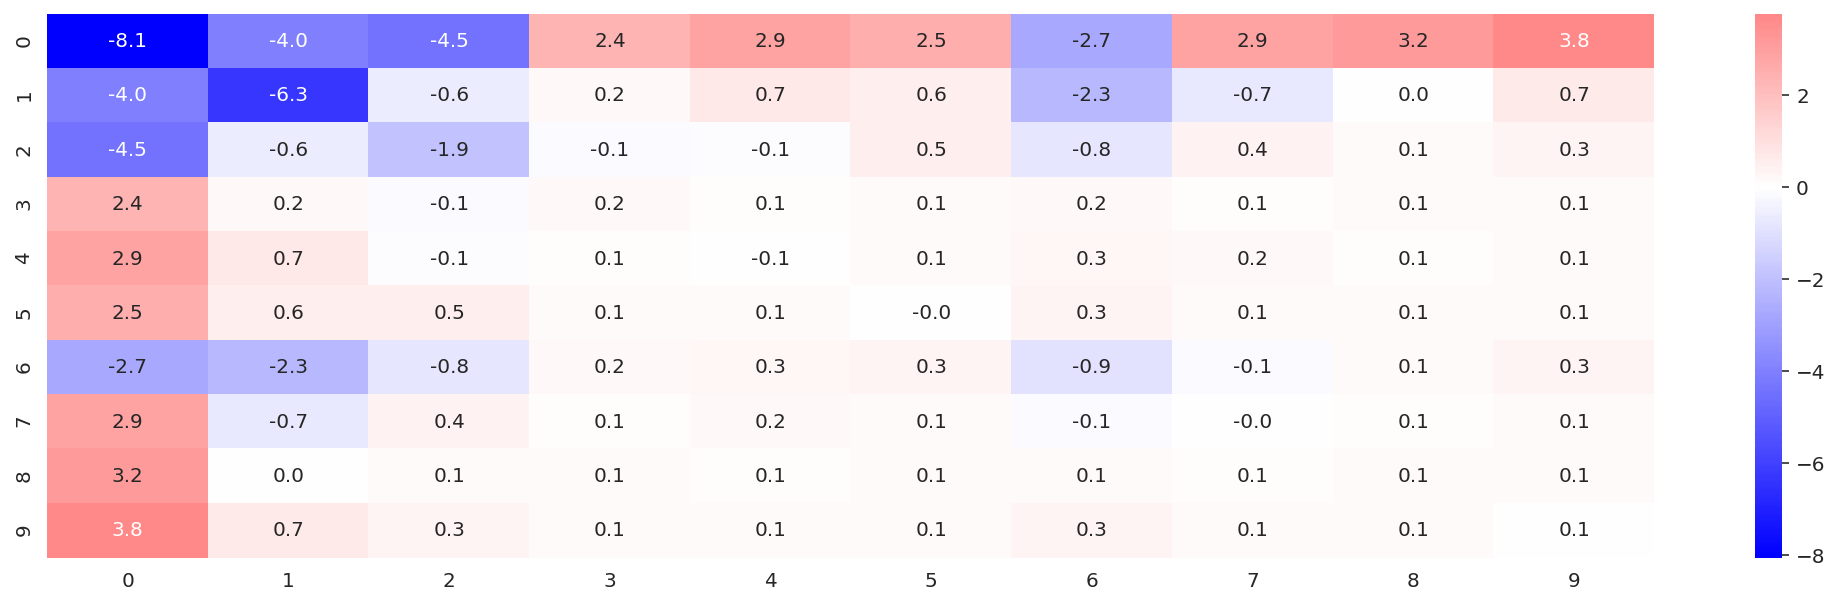

In [7]:
Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
fig, axes = plt.subplots(1, 1, figsize=(18, 5), squeeze=False)
kwargs = dict(
    annot=True,
    fmt='.1f',
    cmap='bwr',
    center=0,
)
for ax, x in zip(axes.flat, [Sigma_x_inv]):
    sns.heatmap(x, ax=ax, **kwargs)

0.6982606795632881


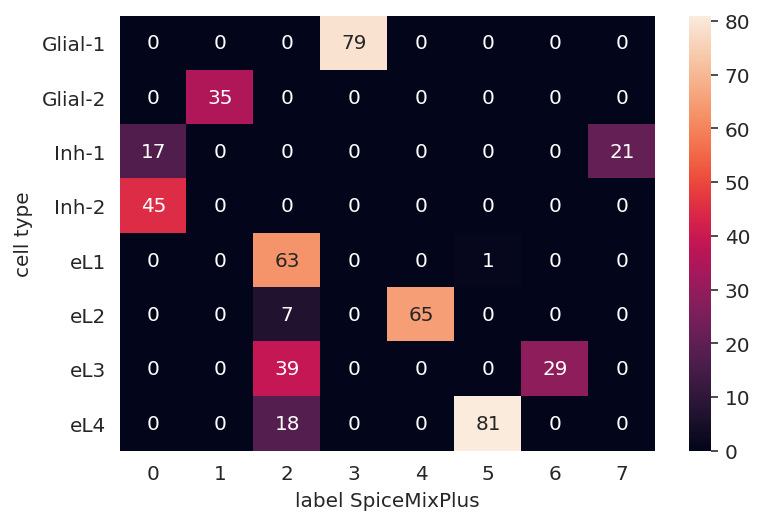

In [44]:
x = obj.Xs[0].cpu().numpy()
x = StandardScaler().fit_transform(x)
y = AgglomerativeClustering(
    n_clusters=8,
    linkage='ward',
).fit_predict(x)
df_meta['label SpiceMixPlus'] = y
print(adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
plt.figure()
sns.heatmap(
    df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
    annot=True, fmt='d',
)
plt.show()
plt.close()

0.8376879369441


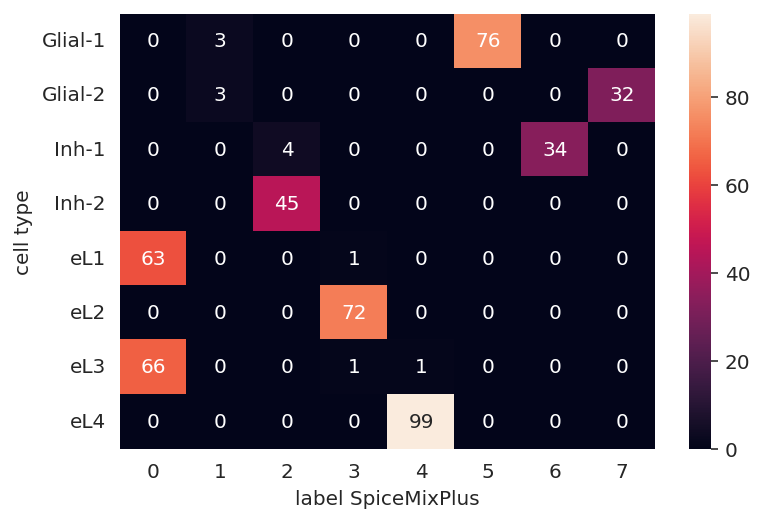

In [29]:
x = obj.Xs[0].cpu().numpy()
x = StandardScaler().fit_transform(x)
y = AgglomerativeClustering(
    n_clusters=8,
    linkage='ward',
).fit_predict(x)
df_meta['label SpiceMixPlus'] = y
print(adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
plt.figure()
sns.heatmap(
    df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
    annot=True, fmt='d',
)
plt.show()
plt.close()

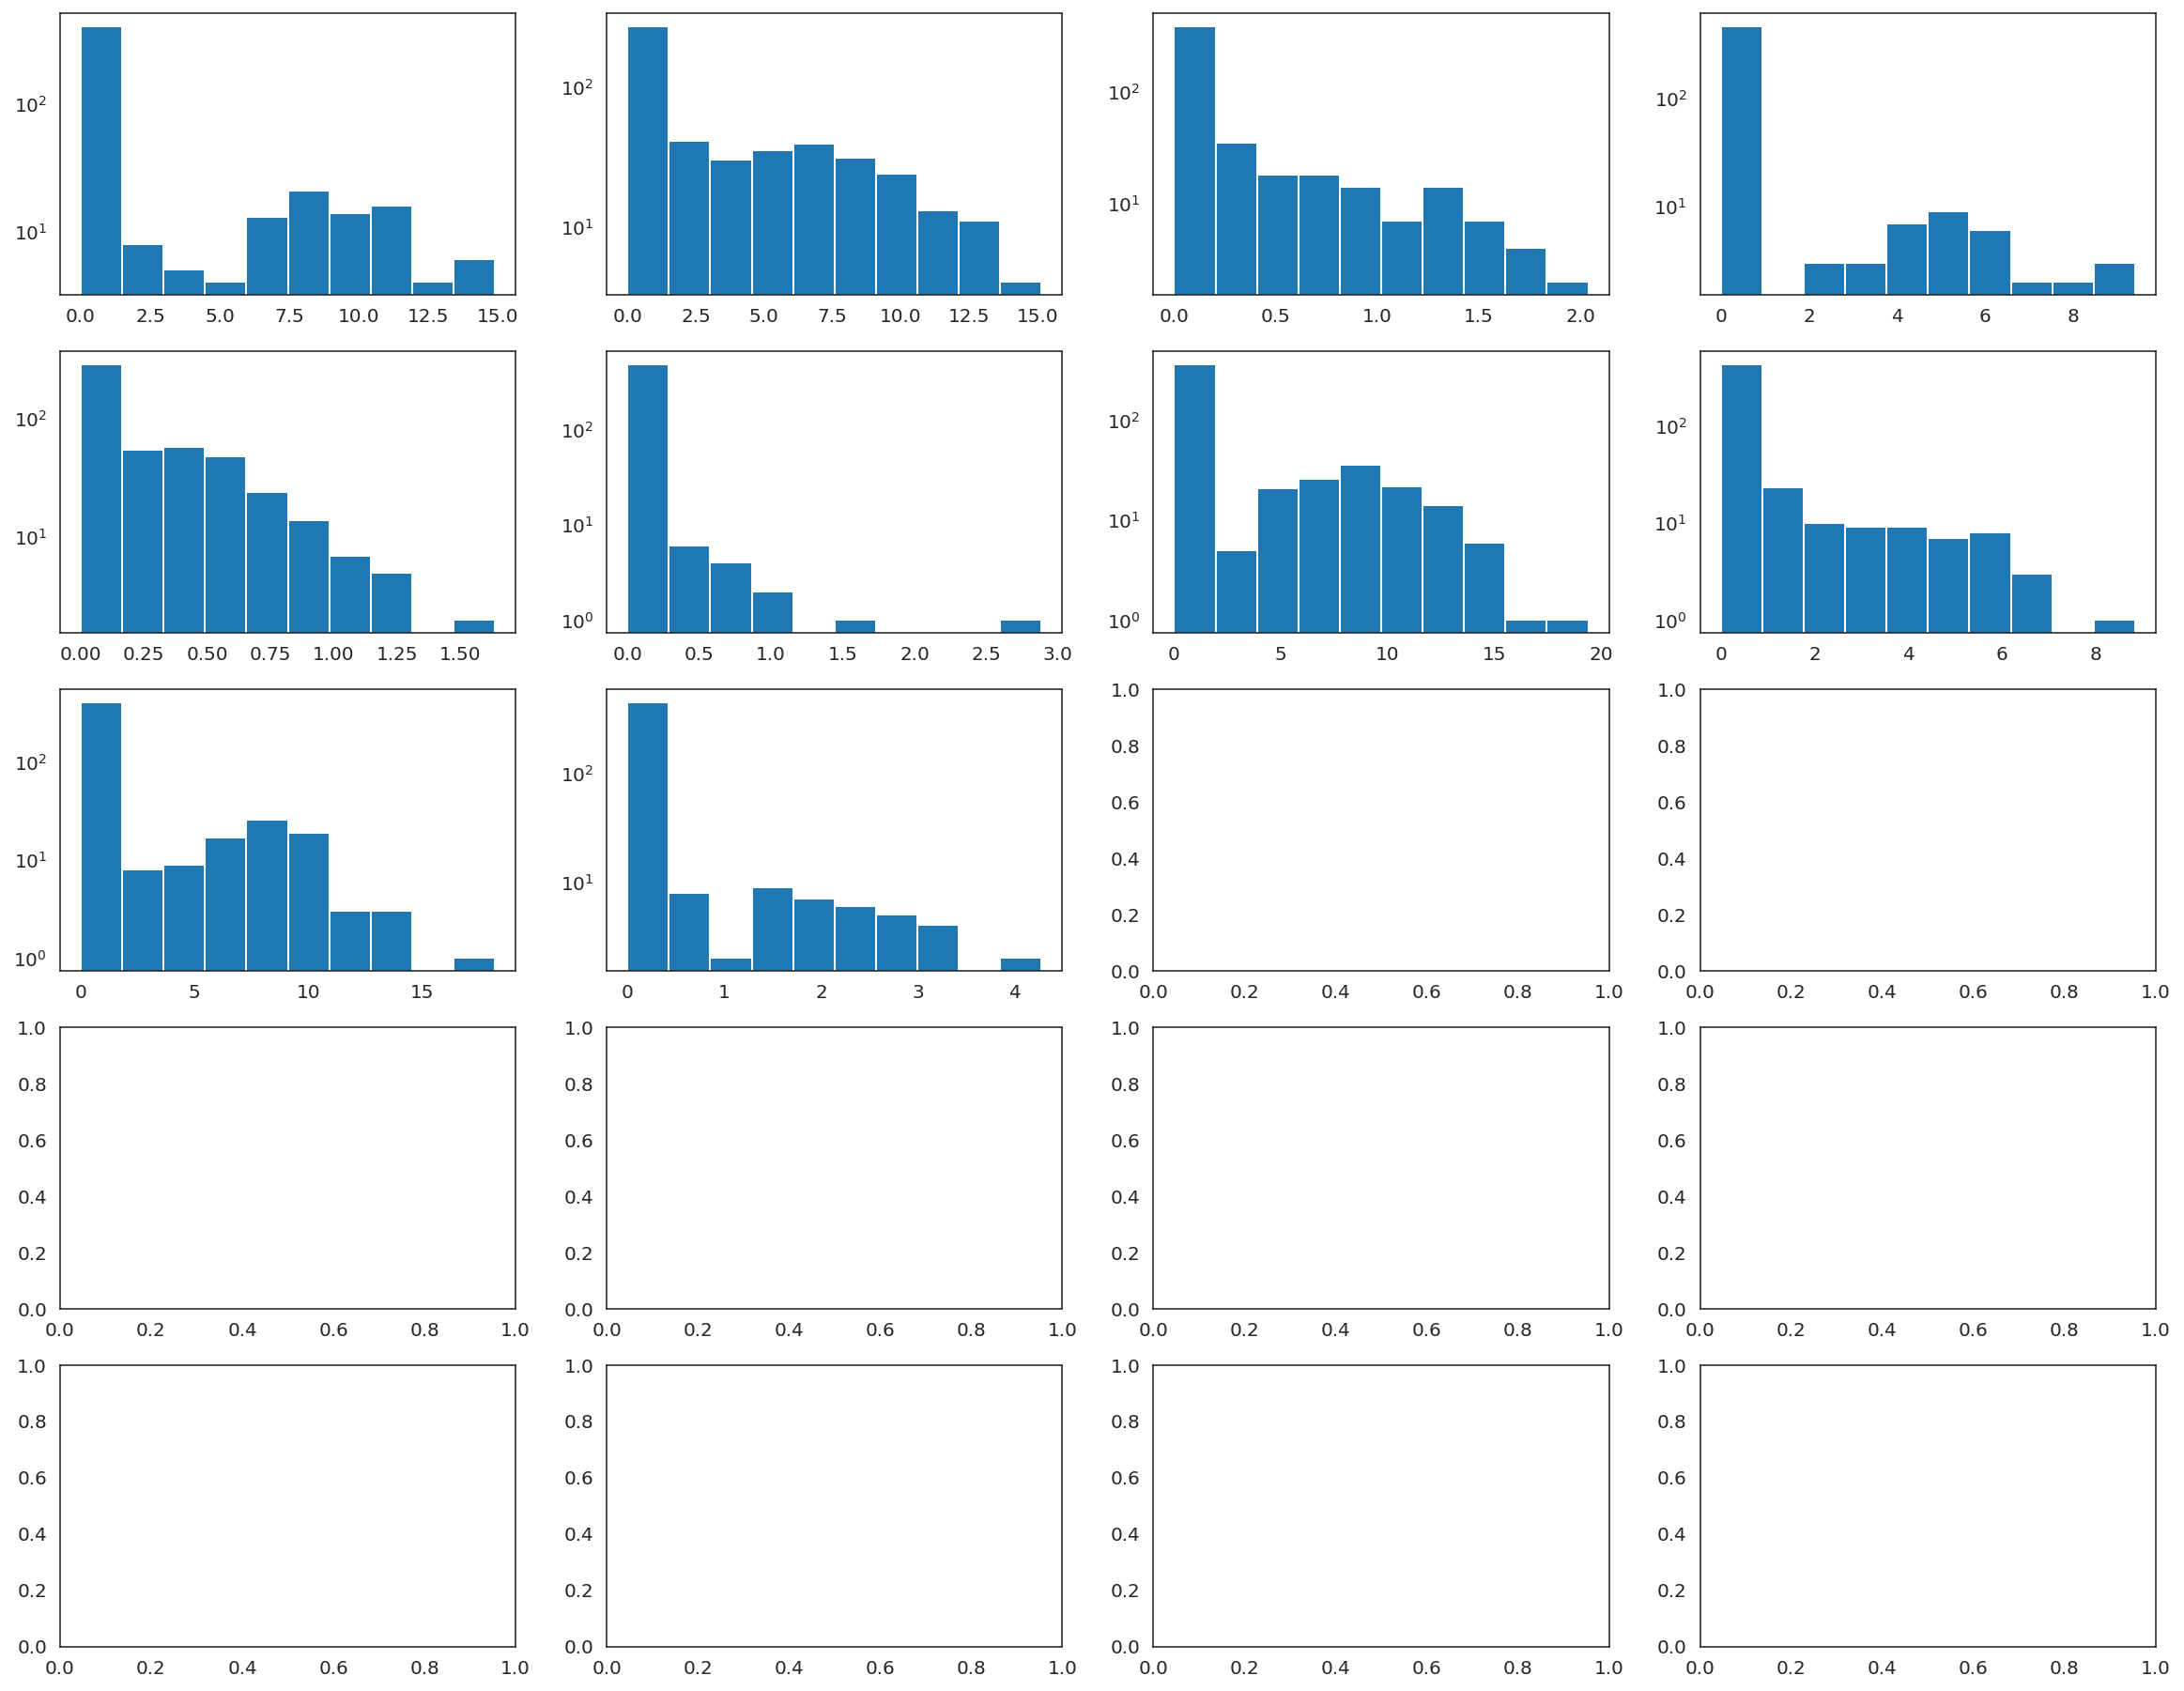

In [34]:
X = obj.Xs[0].cpu().numpy()
fig, axes = plt.subplots(5, 4, figsize=(20, 16))
for ax, x in zip(axes.flat, X.T):
    ax.hist(x)
    ax.set(yscale='log')

In [322]:
# %debug

# Optimization of Σx-1
The convergence is fast. After convergence, it fluctuates around the optimal point, when using Adam as the optimizer.

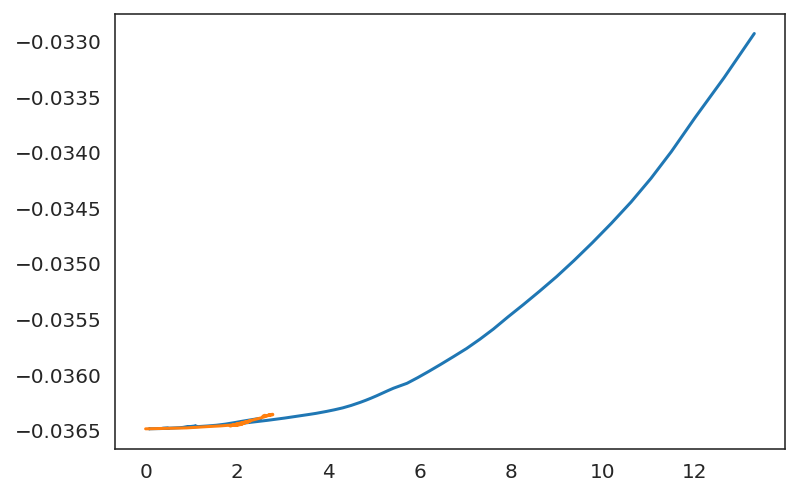

In [363]:
x = np.array([np.linalg.norm(s - Sigma_x_inv) for s, l in history])
y = np.array([l for s, l in history])
i = np.where(x == 0)[0][0]
plt.plot(x[:i], y[:i], c='C0')
plt.plot(x[i:], y[i:], c='C1')

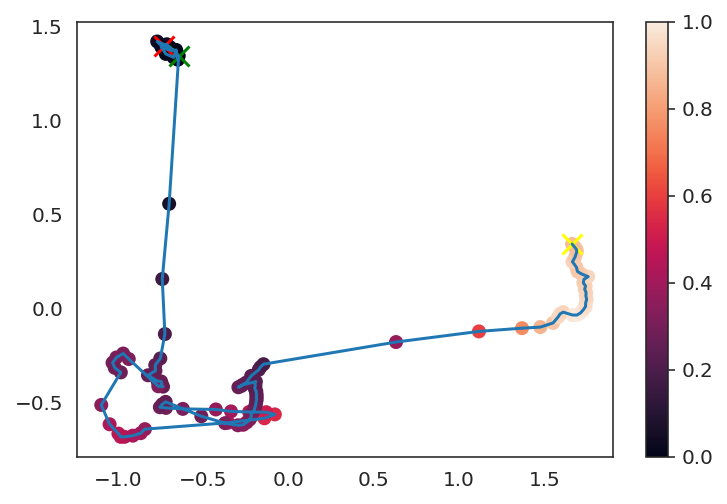

In [364]:
j = i - 20
# j = i
# j = 0
x = np.stack(list(zip(*history))[0][j:])
x = PCA(2).fit_transform(x.reshape(len(x), -1))
plt.plot(x[:, 0], x[:, 1])
plt.scatter(*x.T, c=y[j:])
plt.scatter(*x[[0]].T, c='red', s=100, marker='x')
plt.scatter(*x[[i-j]].T, c='green', s=100, marker='x')
plt.scatter(*x[[-1]].T, c='yellow', s=100, marker='x')
plt.colorbar()

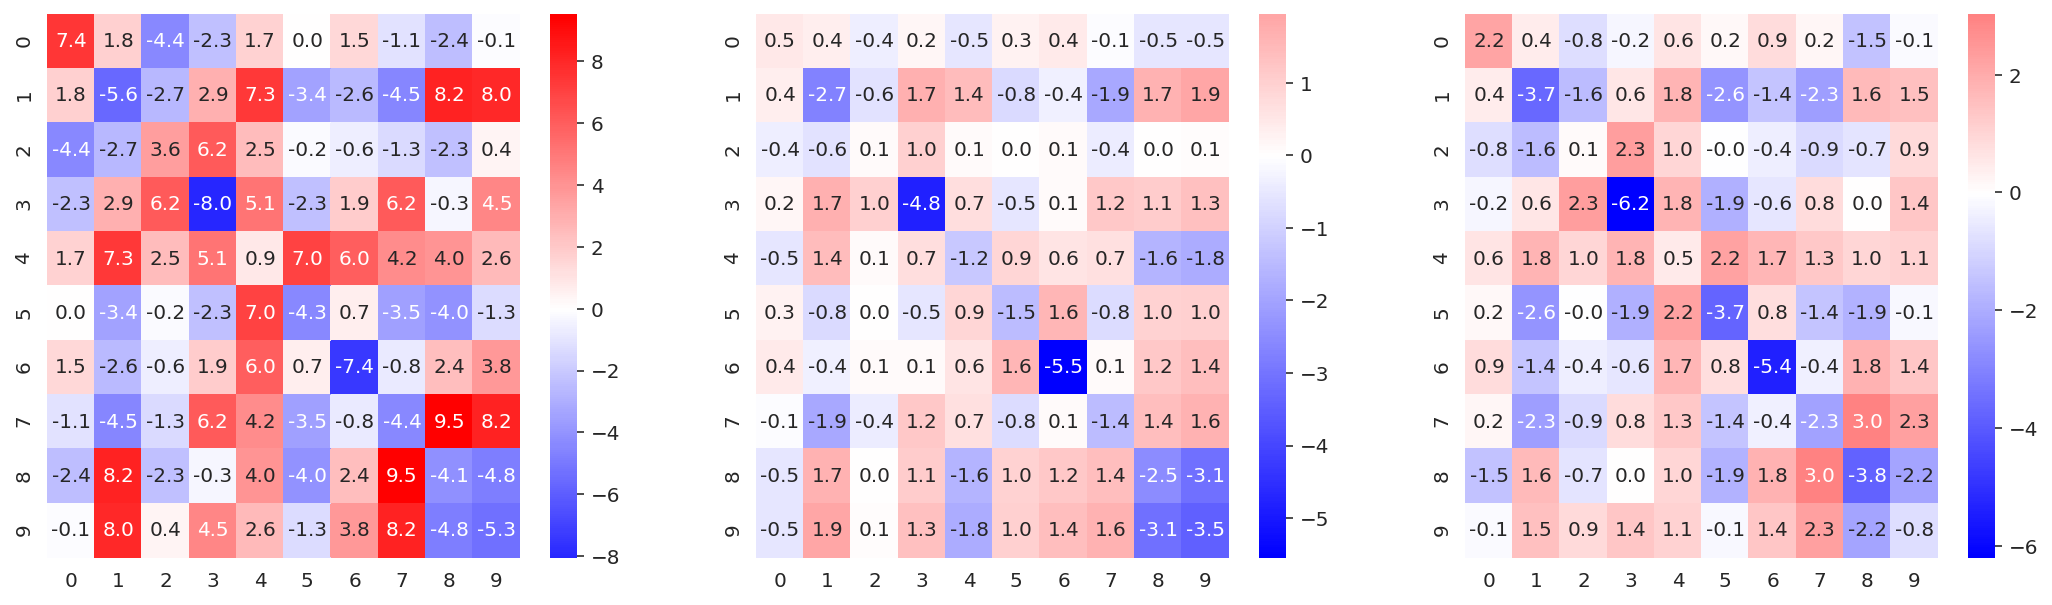

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(
    annot=True,
    fmt='.1f',
    cmap='bwr',
    center=0,
)
for ax, x in zip(axes.flat, [Sigma_x_inv_old, Sigma_x_inv_init, Sigma_x_inv]):
    sns.heatmap(x, ax=ax, **kwargs)

# for debug

In [26]:
# %%time
reload_all()
from model import SpiceMixPlus
from util import clustering_louvain_nclust
from sklearn.cluster import AgglomerativeClustering

def do_umap(obj):
    Xs = [X.cpu().numpy() for X in obj.Xs]

    x = np.concatenate(Xs, axis=0)
    x = StandardScaler().fit_transform(x)
    
#     y = AgglomerativeClustering(
#         n_clusters=8,
#         linkage='ward',
#     ).fit_predict(x)
#     y = pd.Categorical(y, categories=np.unique(y))
    y = clustering_louvain_nclust(
        x.copy(), 8,
        kwargs_neighbors=dict(n_neighbors=10),
        kwargs_clustering=dict(),
        resolution_boundaries=(.1, 1.),
    )
#     print(y)
    df_meta['label SpiceMixPlus'] = y
    print('ari', adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
    plt.figure()
    sns.heatmap(
        df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
        annot=True, fmt='d',
    )
    plt.show()
    plt.close()
    
    x = UMAP(
        n_neighbors=10,
    ).fit_transform(x)
    print('sil', silhouette_score(x, df_meta['cell type']))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, key in zip(axes.flat, ['cell type', 'repli', 'label SpiceMixPlus']):
        sns.scatterplot(ax=ax, data=df_meta, x=x[:, 0], y=x[:, 1], hue=key, s=5)
    plt.show()
    plt.close()

@torch.no_grad()
def load_params(obj, path2result, iiter, load_X=True, load_M=True, load_Sigma_x_inv=True):
    with h5py.File(path2result, 'r') as f:
        if load_X:
            for i, repli in enumerate(obj.repli_list):
                obj.Xs[i][:] = torch.tensor(f[f'latent_states/XT/{repli}/{iiter}'][()], **context)
        if load_M:
            obj.M[:] = torch.tensor(f[f'parameters/M/{iiter}'][()], **context)
        if load_Sigma_x_inv:
            obj.Sigma_x_inv[:] = torch.tensor(f[f'parameters/Sigma_x_inv/{iiter}'][()], **context)

obj = SpiceMixPlus(
    K=10, lambda_Sigma_x_inv=1e-5,
    repli_list=repli_list,
    context=context,
    context_Y=dict(dtype=torch.float32, device='cpu'),
)
obj.load_dataset(path2dataset)
obj.initialize(
#     method='kmeans',
    method='svd',
    random_state=4,
)
# do_umap(obj)
for iiter in trange(10):
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
# do_umap(obj)
# obj.initialize_Sigma_x_inv()
# # path2result = Path(
# #     '/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/'
# #     'synthetic_500_100_20_15_0_0_i4/results/SpiceMix_nFOVs1_K10_rs4_1e-4_lx1.h5'
# # )
# # load_params(obj, path2result, 0, load_Sigma_x_inv=False)
# # load_params(obj, path2result, 0, load_Sigma_x_inv=True)
# obj.initialize_Sigma_x_inv()
# Sigma_x_inv_init = obj.Sigma_x_inv.detach().cpu().numpy()
# # load_params(obj, path2result, 100, load_X=False, load_M=False)
# # load_params(obj, path2result, 10, load_X=False, load_M=False)
# Sigma_x_inv_old = obj.Sigma_x_inv.detach().cpu().numpy()
# # history = obj.estimate_parameters(iiter=0, use_spatial=[True]*obj.num_repli)
# Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
# do_umap(obj)
# for iiter in range(1, 21):
#     obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli, update_Sigma_x_inv=True)
#     obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
#     if iiter % 5 == 0:
#         do_umap(obj)

  0%|          | 0/10 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Updating M:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]